<a href="https://colab.research.google.com/github/shionguha/inf2178-expdesignfordatascience-w23/blob/main/notebooks/t_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Class***
INF2178 

***Authors***
Yu Wan, Kristina Foster

***Date***
April 16th, 2023

# Imports and Preprocessing

In [2]:
# import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from scipy import stats 
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import make_classification

#Clean data
def cleandata(filename):
    """
    Takes in csv file name in the format 'file_name.csv'
    Collapses Action at Arrest variables into a list of actions associated with each arrest
    Returns cleaned dataframe 
    """
    event_data = pd.read_csv(filename)
    
    # Checking for duplicate rows
    duplicate_rows_df = event_data[event_data.duplicated()]
    print('Number of duplicate rows: ', duplicate_rows_df.shape)
    
    # Remove "Nan" and "Legacy" arrests from the dataset
    event_data = event_data[(event_data['Perceived_Race'] != 'Unknown or Legacy')]
    
    return event_data

# Experimental Design Analysis

## Attributes and levels for arrest_data

### Observational units

* Arrest 

### Race
Represents the race that the officers perceived when looking at the arrestee.

dataType = Object
* 'White'
* 'Unknown or Legacy'
* 'Black'
* 'South Asian'
* 'Indigenous',
* 'Middle-Eastern'
* 'Latino', 
* 'East/Southeast Asian'
* NaN

### Sex
Represents the sex assigned at birth for the arrestee.

dataType = Object
* F — Female
* M — Male
* U — Unknown

### Age
dataType = Object
* 'Aged 17 years and under'
* 'Aged 17 years and younger'
* 'Aged 18 to 24 years'
* 'Aged 25 to 34 years'
* 'Aged 35 to 44 years'
* 'Aged 45 to 54 years'
* 'Aged 55 to 64 years'
* 'Aged 65 years and older'
* 'Aged 65 and older'

### StripSearch
Represents if the individual has been strip searched or not.

dataType = Integer
* 0 — Has not been strip-searched
* 1 — Was strip-searched

## Exploring frequency across discrete variables

In [3]:
#Generate raw dataset
arrest_data = pd.read_csv('inf2178_midterm_data.csv')

#for event in event_arrests_data:
arrest_data = cleandata('inf2178_midterm_data.csv')
print("Number of unique arrests: " + str(arrest_data.shape[0]))

Number of duplicate rows:  (0, 25)
Number of unique arrests: 60220


## Discrete marginal distributions

In [4]:
#Create discrete continuous variable for marginal distribution across arrest reasons

#Function to return a PMF of an array of variables
#Source: https://allendowney.github.io/BiteSizeBayes/10_joint.html
def pmf_from_seq(seq):
    """Make a PMF from a sequence of values.
    
    seq: sequence
    
    returns: Series representing a PMF
    """
    pmf = pd.Series(seq).value_counts(sort=False).sort_index()
    pmf /= pmf.sum()
    return pmf

### Perceived Race

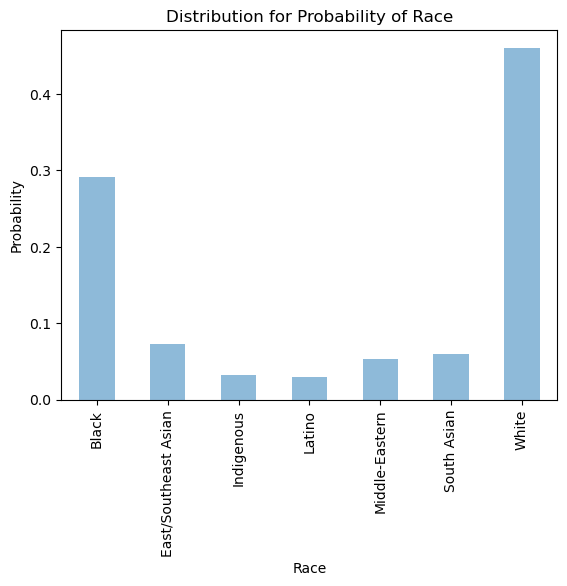

In [5]:
#PMF for perceived race
race_arrest = pmf_from_seq(arrest_data["Perceived_Race"])
race_arrest.plot.bar(color='C0', alpha=0.5)
plt.xlabel('Race')
plt.ylabel('Probability')
plt.title('Distribution for Probability of Race');

### Sex

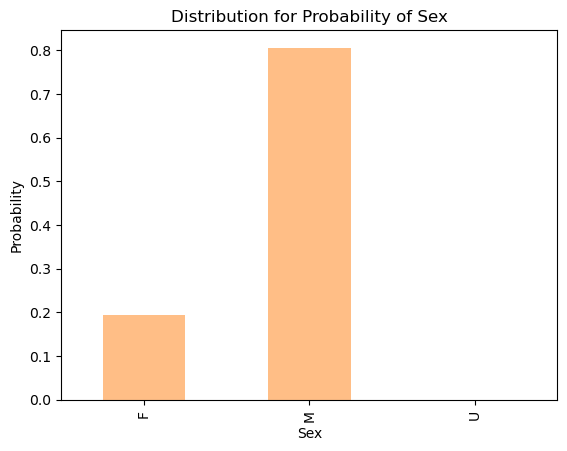

In [6]:
#PMF for sex
sex_arrest = pmf_from_seq(arrest_data["Sex"])
sex_arrest.plot.bar(color='C1', alpha=0.5)
plt.xlabel('Sex')
plt.ylabel('Probability')
plt.title('Distribution for Probability of Sex');

### Age

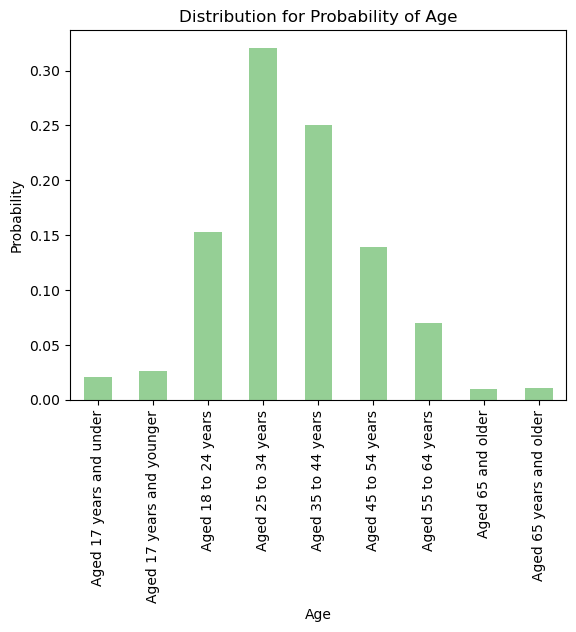

In [7]:
#PMF for age
age_arrest = pmf_from_seq(arrest_data["Age_group__at_arrest_"])
age_arrest.plot.bar(color='C2', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Probability')
plt.title('Distribution for Probability of Age');

### Strip-Searched

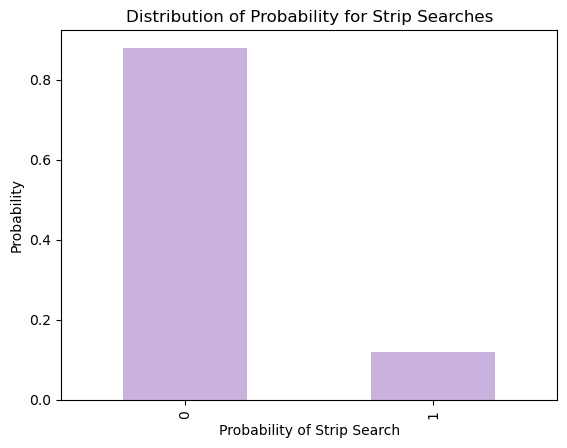

In [8]:
#PMF for strip-searched
stripped_arrest = pmf_from_seq(arrest_data["StripSearch"])
stripped_arrest.plot.bar(color='C4', alpha=0.5)
plt.xlabel('Probability of Strip Search')
plt.ylabel('Probability')
plt.title('Distribution of Probability for Strip Searches');

## Joint Distribution

In [9]:
#Source: https://allendowney.github.io/BiteSizeBayes/10_joint.html
def plot_heatmap(xtab):
    """Make a heatmap to represent a cross tabulation.
    xtab: DataFrame containing a cross tabulation
    """
    plt.pcolormesh(xtab)

    # label the y axis
    ys = xtab.index
    plt.ylabel(ys.name)
    locs = np.arange(len(ys)) + 0.5
    plt.yticks(locs, ys)

    # label the x axis
    xs = xtab.columns
    plt.xlabel(xs.name)
    locs = np.arange(len(xs)) + 0.5
    plt.xticks(locs, xs)
    
    plt.colorbar()
    plt.gca().invert_yaxis()


### Perceived Race <> Strip Searches

In [10]:
#Constructing crosstab for Joint PMF
ct_race_stripsearch = pd.crosstab(index=arrest_data["Perceived_Race"], columns=arrest_data["StripSearch"], normalize=True)

#Display header of Joint PMF
ct_race_stripsearch.head()

StripSearch,0,1
Perceived_Race,,
Black,0.250631,0.040421
East/Southeast Asian,0.067656,0.005663
Indigenous,0.027036,0.005082
Latino,0.027169,0.002192
Middle-Eastern,0.049970,0.003786


### Sex <> Strip Searches

In [11]:
#Constructing crosstab for Joint PMF
ct_sex_stripsearch = pd.crosstab(index=arrest_data["Sex"], columns=arrest_data["StripSearch"], normalize=True)

#Display header of Joint PMF
ct_sex_stripsearch.head()

StripSearch,0,1
Sex,,
F,0.174427,0.019711
M,0.704832,0.100930
U,0.000100,0.000000


### Age <> Strip Searches

In [12]:
#Constructing crosstab for Joint PMF
ct_age_stripsearch = pd.crosstab(index=arrest_data["Age_group__at_arrest_"], columns=arrest_data["StripSearch"], normalize=True)

#Display header of Joint PMF
ct_age_stripsearch.head()

StripSearch,0,1
Age_group__at_arrest_,,
Aged 17 years and under,0.020616,0.000150
Aged 17 years and younger,0.022011,0.004153
Aged 18 to 24 years,0.131900,0.020682
Aged 25 to 34 years,0.278120,0.042544
Aged 35 to 44 years,0.217287,0.032709


## Joint Distribution Scatterplots

### Perceived Race <> Strip Searches

In [13]:
#Create Occurrence Category joint distributions for race and strip-searches
stripped_race = arrest_data[arrest_data['StripSearch'] == 1].copy()
not_stripped_race = arrest_data[arrest_data["StripSearch"] != 1].copy()

#determine normalized joint distribution for strip-searches
joint_freq_stripped_race = stripped_race['Perceived_Race'].value_counts()/7265
joint_freq_not_stripped_race = not_stripped_race['Perceived_Race'].value_counts()/52955

#Add columns store joint distributions frequency of levels of perceived race
stripped_race['Race_joint'] = stripped_race['Perceived_Race'].map(joint_freq_stripped_race)
not_stripped_race['Race_joint2'] = not_stripped_race['Perceived_Race'].map(joint_freq_not_stripped_race)
                                                 
#Concatenate datasets
arrest_data = pd.concat([stripped_race,not_stripped_race]).copy()

#Merge both joint distributions into one column
arrest_data['Perceived_Race_joint_merged'] = arrest_data[['Race_joint','Race_joint2']].bfill(axis=1).iloc[:, 0]

#Add a categorical scale for race
arrest_data["Perceived_Race"] = arrest_data["Perceived_Race"].astype('category')
arrest_data["Perceived_Race_Category"] = arrest_data["Perceived_Race"].cat.codes

arrest_data.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId,Race_joint,Race_joint2,Perceived_Race_joint_merged,Perceived_Race_Category
12,2021,Apr-June,1039002,6030241.0,330778,Black,M,Aged 25 to 34 years,Not a youth,53,...,1.0,1.0,1.0,0.0,0.0,13,0.335031,NaN,0.335031,0
14,2020,Apr-June,1045382,6057058.0,312724,Black,M,Aged 25 to 34 years,Not a youth,53,...,1.0,1.0,1.0,0.0,0.0,15,0.335031,NaN,0.335031,0
33,2021,Jan-Mar,1026070,6064426.0,323427,White,M,Aged 35 to 44 years,Not a youth,53,...,0.0,0.0,1.0,1.0,0.0,34,0.490847,NaN,0.490847,6
38,2020,Apr-June,1028958,6057012.0,319209,Latino,M,Aged 18 to 24 years,Not a youth,XX,...,1.0,0.0,1.0,0.0,0.0,39,0.018169,NaN,0.018169,3
42,2020,July-Sept,1026364,6027584.0,316419,South Asian,F,Aged 25 to 34 years,Not a youth,52,...,1.0,0.0,0.0,0.0,0.0,43,0.035375,NaN,0.035375,5


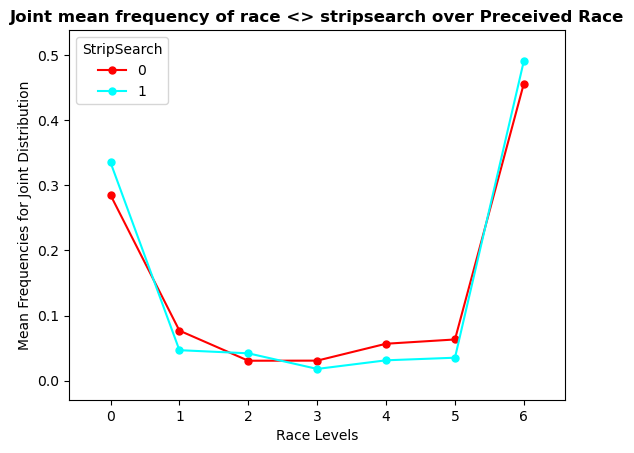

In [14]:
#Interaction for joint race <> strip-search
strip_search = arrest_data["StripSearch"].astype("category")
joint_occur_freq = arrest_data["Perceived_Race_joint_merged"].values

interaction_plot_freq = interaction_plot(arrest_data["Perceived_Race_Category"], strip_search, joint_occur_freq, ms=10)
plt.ylabel('Mean Frequencies for Joint Distribution')
plt.xlabel('Race Levels')
plt.title('Joint mean frequency of race <> stripsearch over Preceived Race', fontweight='bold')
plt.show()

### Sex <> Strip Searches

In [15]:
#Create joint distributions for sex and strip-searches
stripped_sex = arrest_data[arrest_data['StripSearch'] == 1].copy()
not_stripped_sex = arrest_data[arrest_data["StripSearch"] != 1].copy()

#determine normalized joint distribution for strip-searches
joint_freq_stripped_sex = stripped_sex['Sex'].value_counts()/7265
joint_freq_not_stripped_sex = not_stripped_sex['Sex'].value_counts()/52955

#Add columns store joint distributions of frequency levels of Sex
stripped_sex['Sex_joint'] = stripped_sex['Sex'].map(joint_freq_stripped_sex)
not_stripped_sex['Sex_joint2'] = not_stripped_sex['Sex'].map(joint_freq_not_stripped_sex)
                                             
#Concatenate datasets
arrest_data = pd.concat([stripped_sex,not_stripped_sex]).copy()

#Merge both joint distribution columns into one column
arrest_data['Sex_joint_merged'] = arrest_data[['Sex_joint','Sex_joint2']].bfill(axis=1).iloc[:, 0]
arrest_data.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,SearchReason_PossessEvidence,ItemsFound,ObjectId,Race_joint,Race_joint2,Perceived_Race_joint_merged,Perceived_Race_Category,Sex_joint,Sex_joint2,Sex_joint_merged
12,2021,Apr-June,1039002,6030241.0,330778,Black,M,Aged 25 to 34 years,Not a youth,53,...,0.0,0.0,13,0.335031,NaN,0.335031,0,0.836614,NaN,0.836614
14,2020,Apr-June,1045382,6057058.0,312724,Black,M,Aged 25 to 34 years,Not a youth,53,...,0.0,0.0,15,0.335031,NaN,0.335031,0,0.836614,NaN,0.836614
33,2021,Jan-Mar,1026070,6064426.0,323427,White,M,Aged 35 to 44 years,Not a youth,53,...,1.0,0.0,34,0.490847,NaN,0.490847,6,0.836614,NaN,0.836614
38,2020,Apr-June,1028958,6057012.0,319209,Latino,M,Aged 18 to 24 years,Not a youth,XX,...,0.0,0.0,39,0.018169,NaN,0.018169,3,0.836614,NaN,0.836614
42,2020,July-Sept,1026364,6027584.0,316419,South Asian,F,Aged 25 to 34 years,Not a youth,52,...,0.0,0.0,43,0.035375,NaN,0.035375,5,0.163386,NaN,0.163386


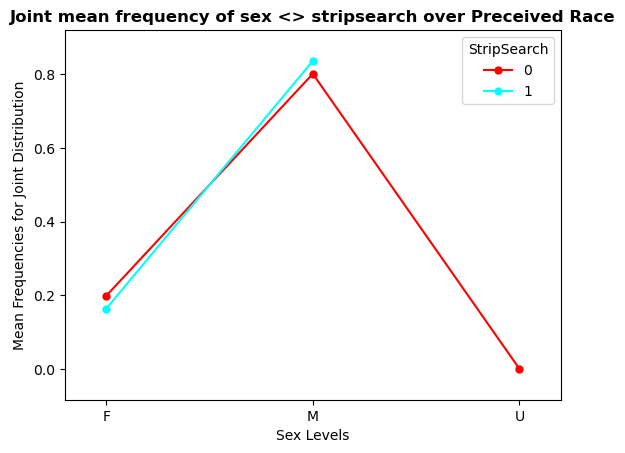

In [16]:
#Interaction for joint sex <> strip-search
strip_search = arrest_data["StripSearch"].astype("category")
joint_occur_freq = arrest_data["Sex_joint_merged"].values

interaction_plot_freq = interaction_plot(arrest_data["Sex"], strip_search, joint_occur_freq, ms=10)
plt.ylabel('Mean Frequencies for Joint Distribution')
plt.xlabel('Sex Levels')
plt.title('Joint mean frequency of sex <> stripsearch over Preceived Race', fontweight='bold')
plt.show()

### Age <> Strip Searches

In [17]:
#Create joint distributions for age and strip-searches
stripped_age = arrest_data[arrest_data['StripSearch'] == 1].copy()
not_stripped_age = arrest_data[arrest_data["StripSearch"] != 1].copy()

#determine joint distribution for arrests
joint_freq_stripped_age = stripped_age['Age_group__at_arrest_'].value_counts()/7265
joint_freq_not_stripped_age = not_stripped_age['Age_group__at_arrest_'].value_counts()/52955

#Add columns store joint distributions of frequency levels of Sex
stripped_age['Age_joint'] = stripped_age['Age_group__at_arrest_'].map(joint_freq_stripped_age)
not_stripped_age['Age_joint2'] = not_stripped_age['Age_group__at_arrest_'].map(joint_freq_not_stripped_age)
                                             
#Concatenate datasets
arrest_data = pd.concat([stripped_age,not_stripped_age]).copy()

#Merge both joint distributions into one column
arrest_data['Age_joint_merged'] = arrest_data[['Age_joint','Age_joint2']].bfill(axis=1).iloc[:, 0]

#Add a categorical scale for age
arrest_data["Age_group__at_arrest_"] = arrest_data["Age_group__at_arrest_"].astype('category')
arrest_data["Age_Category"] = arrest_data["Age_group__at_arrest_"].cat.codes

arrest_data.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Race_joint2,Perceived_Race_joint_merged,Perceived_Race_Category,Sex_joint,Sex_joint2,Sex_joint_merged,Age_joint,Age_joint2,Age_joint_merged,Age_Category
12,2021,Apr-June,1039002,6030241.0,330778,Black,M,Aged 25 to 34 years,Not a youth,53,...,NaN,0.335031,0,0.836614,NaN,0.836614,0.352512,NaN,0.352512,3
14,2020,Apr-June,1045382,6057058.0,312724,Black,M,Aged 25 to 34 years,Not a youth,53,...,NaN,0.335031,0,0.836614,NaN,0.836614,0.352512,NaN,0.352512,3
33,2021,Jan-Mar,1026070,6064426.0,323427,White,M,Aged 35 to 44 years,Not a youth,53,...,NaN,0.490847,6,0.836614,NaN,0.836614,0.271025,NaN,0.271025,4
38,2020,Apr-June,1028958,6057012.0,319209,Latino,M,Aged 18 to 24 years,Not a youth,XX,...,NaN,0.018169,3,0.836614,NaN,0.836614,0.171370,NaN,0.171370,2
42,2020,July-Sept,1026364,6027584.0,316419,South Asian,F,Aged 25 to 34 years,Not a youth,52,...,NaN,0.035375,5,0.163386,NaN,0.163386,0.352512,NaN,0.352512,3


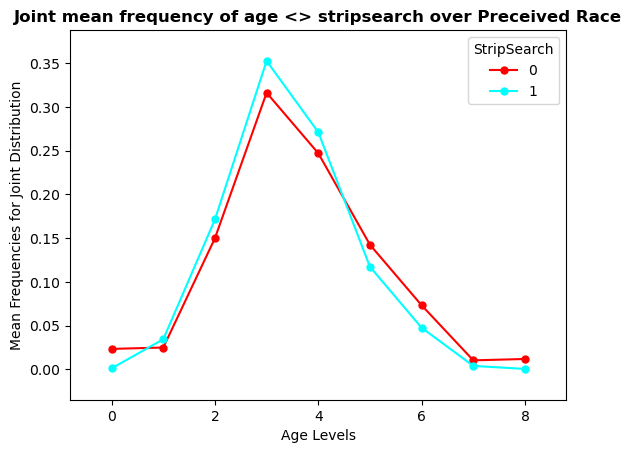

In [18]:
#Interaction for joint age <> strip-search
strip_search = arrest_data["StripSearch"].astype("category")
joint_occur_freq = arrest_data["Age_joint_merged"].values

interaction_plot_freq = interaction_plot(arrest_data["Age_Category"], strip_search, joint_occur_freq, ms=10)
plt.ylabel('Mean Frequencies for Joint Distribution')
plt.xlabel('Age Levels')
plt.title('Joint mean frequency of age <> stripsearch over Preceived Race', fontweight='bold')
plt.show()

# Testing default, model minorities, and not model minorities

## Create conditional distributions for strip-searches given model minority, not, or default

| Level | Model Minority (1) | Not Model Minority (2) | White (Default) (0) | All |
|-----:|-----:|-----:|-----:|-----:|
| Strip Searched (1) | East/Southeast Asian(341) + Middle-Eastern(228) + South Asian(257) + Latino(132) = 958 | Black(2434) + Indigenous(306) = 2740 | 3566 | 7269 |
| Not Strip Searched (0) | East/Southeast Asian(4074) + Middle-Eastern(3009) + South Asian(3356) + Latino(1636) = 12075 | Black(15092) + Indigenous(1628) = 16720 | 24157 | 52955 |
| All | 13033 | 19460 | 27727 | 60220 |

### Add new column for model minority category

In [19]:
# Label and mapping for model minority 
conditions = [
    (arrest_data['Perceived_Race'] == "East/Southeast Asian") | (arrest_data['Perceived_Race'] == "Middle-Eastern")  | (arrest_data['Perceived_Race'] == "South Asian")  | (arrest_data['Perceived_Race'] == "Latino"),
    (arrest_data['Perceived_Race'] == "Indigenous") | (arrest_data['Perceived_Race'] == "Black"),
    (arrest_data['Perceived_Race'] == "White"),
    ]

#Create a list of the values we want to assign for each condition
values = ['Model Minority', 'Not Model Minority', 'Default']

#Create a new column and use np.select to assign values to it using our lists as arguments and create a category
arrest_data['Model_Minorities_Category'] = np.select(conditions, values)
arrest_data['Model_Minorities_Category'] = arrest_data['Model_Minorities_Category'].astype('category')

## Check power of each group with a large effect area (0.8) and alpha (0.005)

In [20]:
from statsmodels.stats.power import TTestPower

#Power for model minorities who are strip-searched
power = TTestPower()
n_test = power.solve_power(nobs=958, effect_size = 0.8, power = None, alpha = 0.005)
print('Power for arrestees classified as model minorities who were strip-searched: {:.3f}'.format(n_test))

#Power for not model minorities who are strip-searched
n_test = power.solve_power(nobs=2740, effect_size = 0.8, power = None, alpha = 0.005)
print('Power for arrestees classified as not model minorities who were strip-searched: {:.3f}'.format(n_test))

#Power for white (default) who are strip-searched
n_test = power.solve_power(nobs=3566, effect_size = 0.8, power = None, alpha = 0.005)
print('Power for arrestees classified as white who were strip-searched: {:.3f}'.format(n_test))

#Power for model minorities who are not strip-searched
power = TTestPower()
n_test = power.solve_power(nobs=12075, effect_size = 0.8, power = None, alpha = 0.005)
print('Power for arrestees classified as model minorities who were strip-searched: {:.3f}'.format(n_test))

#Power for not model minorities who are not strip-searched
n_test = power.solve_power(nobs=16720, effect_size = 0.8, power = None, alpha = 0.005)
print('Power for arrestees classified as not model minorities who were strip-searched: {:.3f}'.format(n_test))

#Power for white (default) who are not strip-searched
n_test = power.solve_power(nobs=24157, effect_size = 0.8, power = None, alpha = 0.005)
print('Power for arrestees classified as white who were strip-searched: {:.3f}'.format(n_test))


Power for arrestees classified as model minorities who were strip-searched: 1.000
Power for arrestees classified as not model minorities who were strip-searched: 1.000
Power for arrestees classified as white who were strip-searched: 1.000
Power for arrestees classified as model minorities who were strip-searched: 1.000
Power for arrestees classified as not model minorities who were strip-searched: 1.000
Power for arrestees classified as white who were strip-searched: 1.000


## T-Test between types of race

### Black vs Not Black

In [21]:
# Divide the data into two subset that include only black and the rest of the races
black = arrest_data[arrest_data['Perceived_Race'] == 'Black']
rest_race = arrest_data[arrest_data['Perceived_Race'] != 'Black']

# Caculate the mean  for each subset
black_prob1 = black['StripSearch'].mean()
rest_race_prob1 = rest_race['StripSearch'].mean()

# Calculate the t-test and get p-value
t_stat, p_value = ttest_ind(black['StripSearch'], rest_race['StripSearch'], equal_var=False)

print('mean of black people:',black_prob1)
print('mean of rest race:',rest_race_prob1)
print('t_stat:',t_stat)
print('p_val:',p_value)

mean of black people: 0.13887937920803378
mean of rest race: 0.11315407317187427
t_stat: 8.493122950728434
p_val: 2.1024389591947247e-17


### White vs Non White

In [22]:
# Divide the data into two subset that include only white and the rest of the races
white = arrest_data[arrest_data['Perceived_Race'] == 'White']
rest_race = arrest_data[arrest_data['Perceived_Race'] != 'White']

# Caculate the mean  for each subset
white_prob1 = white['StripSearch'].mean()
rest_race_prob1 = rest_race['StripSearch'].mean()

# Calculate the t-test and get p-value
t_stat, p_value = ttest_ind(white['StripSearch'], rest_race['StripSearch'], equal_var=False)

print('mean of white people:',white_prob1)
print('mean of rest race:',rest_race_prob1)
print('t_stat:',t_stat)
print('p_val:',p_value)

mean of white people: 0.12862965768495474
mean of rest race: 0.113825891620765
t_stat: 5.537376686990467
p_val: 3.083707342105717e-08


### Indigenous vs Non Indigenous

In [23]:
# Divide the data into two subset that include only indigenous and the rest of the races
indigenous = arrest_data[arrest_data['Perceived_Race'] == 'Indigenous']
rest_race = arrest_data[arrest_data['Perceived_Race'] != 'Indigenous']

# Caculate the mean  for each subset
indigenous_prob1 = indigenous['StripSearch'].mean()
rest_race_prob1 = rest_race['StripSearch'].mean()

# Calculate the t-test and get p-value
t_stat, p_value = ttest_ind(indigenous['StripSearch'], rest_race['StripSearch'], equal_var=False)

print('mean of indigenous people:',indigenous_prob1)
print('mean of rest race:',rest_race_prob1)
print('t_stat:',t_stat)
print('p_val:',p_value)

mean of indigenous people: 0.15822130299896586
mean of rest race: 0.1193940225783207
t_stat: 4.617528626828796
p_val: 4.125855974631104e-06


### Model Minorities vs Everything Else

In [24]:
# Divide the data into two subset that include only indigenous and the rest of the races
model_minority = arrest_data[arrest_data['Model_Minorities_Category'] == 'Model Minority']
other_levels = arrest_data[arrest_data['Model_Minorities_Category'] != 'Model Minority']

# Caculate the mean  for each subset
model_minority_prob1 = model_minority['StripSearch'].mean()
other_levels_prob1 = other_levels['StripSearch'].mean()

# Calculate the t-test and get p-value
t_stat, p_value = ttest_ind(model_minority['StripSearch'], other_levels['StripSearch'], equal_var=False)

print('mean of minority people:', model_minority_prob1)
print('mean of other levels:', other_levels_prob1)
print('t_stat:',t_stat)
print('p_val:',p_value)

mean of minority people: 0.07350571625872784
mean of other levels: 0.13365969440735795
t_stat: -21.706469696838678
p_val: 1.421497051291217e-103


### Not Model Minorities vs Everything Else

In [25]:
# Divide the data into two subset that include only indigenous and the rest of the races
not_model_minority = arrest_data[arrest_data['Model_Minorities_Category'] == 'Not Model Minority']
other_levels = arrest_data[arrest_data['Model_Minorities_Category'] != 'NotModel Minority']

# Caculate the mean  for each subset
not_model_minority_prob1 = not_model_minority['StripSearch'].mean()
other_levels_prob1 = other_levels['StripSearch'].mean()

# Calculate the t-test and get p-value
t_stat, p_value = ttest_ind(not_model_minority['StripSearch'], other_levels['StripSearch'], equal_var=False)

print('mean of minority people:', not_model_minority_prob1)
print('mean of other levels:', other_levels_prob1)
print('t_stat:',t_stat)
print('p_val:',p_value)

mean of minority people: 0.1408016443987667
mean of other levels: 0.12064098306210562
t_stat: 7.137387549485971
p_val: 9.719383538306733e-13


## Logistic Regression

### Create contingency table

| Level | Model Minority (1) | Not Model Minority (2) | White (Default) (0) | All |
|-----:|-----:|-----:|-----:|-----:|
| Strip Searched (1) | 958 (13%) | 2740 (38%) | 3566 (49%) | 7269 (100%) |
| Not Strip Searched (0) | 12075 (23%) | 16720 (32%) | 24157 (46%) | 52955 (100%) |
| All | 13033 (22%) | 19460 (32%) | 27727 (46%) | 60220 (100%) |

### Create expected values table

| Level | Model Minority (1) | Not Model Minority (2) | White (Default) (0) | All |
|-----:|-----:|-----:|-----:|-----:|
| Strip Searched (1) | 1599.18 | 2326.08 | 3343.74 | 7269 |
| Not Strip Searched (0) | 11650.1 | 16945.6 | 24359.3 | 52955 |
| All | 13033 (22%) | 19460 (32%) | 27727 (46%) | 60220 (100%) |

### χ2 test of Independence

In [26]:
#Hypothesis for independence test
#H₀: The two categorical variables have no relationship
#H₁: There is a relationship between two categorical variables
#Source: https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626

# create contingency table
data_crosstab = pd.crosstab(arrest_data['Model_Minorities_Category'],
                            arrest_data['StripSearch'],
                            margins=True, margins_name="Total")

# significance level
alpha = 0.005

# Calculation of Chisquare
chi_square = 0
rows = arrest_data['Model_Minorities_Category'].unique()
columns = arrest_data['StripSearch'].unique()

for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
print(conclusion)


Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 364.8109136762887  and p value is: 0.0
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 364.8109136762887  and critical value is: 12.838156466598647
Null Hypothesis is rejected.


### χ2 Goodness-Of-Fit test statistics

In [27]:
#Hypothesis for goodness-of-fit test
#H₀: The variable has the specified distribution, i.e. the observed and expected frequencies are roughly equal
#H₁: The variable does not have the specified distribution, not normal

data = [['White (Default)', 0.46, 27727], ['Model Minority', 0.22, 13033], ['Not Model Minority', 0.32, 19460]] 
df = pd.DataFrame(data, columns = ['Varname', 'prob_dist', 'observed_freq']) 
df['expected_freq'] = df['observed_freq'].sum() * df['prob_dist']

# significance level
alpha = 0.05

# Calculation of Chisquare
chi_square = 0
for i in range(len(df)):
    O = df.loc[i, 'observed_freq']
    E = df.loc[i, 'expected_freq']
    chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, df['Varname'].nunique() - 1)
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, df['Varname'].nunique() - 1)
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
print(conclusion)


Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 5.391584611365662  and p value is: 0.0674888887555225
Failed to reject the null hypothesis.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 5.391584611365662  and critical value is: 5.991464547107979
Failed to reject the null hypothesis.


In [28]:
arrest_data = pd.read_csv('inf2178_midterm_data.csv')
arrest_data = arrest_data[arrest_data['Sex'] != 'U']


# create a group contains non-white, non-black,non-indigenous races
race_group  = {  'Unknown or Legacy': 'Minority',
                 'White': 'White',
                 'Black':'Non Minority',
                 'Indigenous':'Non Minority',
                 'South Asian': 'Minority', 
                 'Middle-Eastern': 'Minority',
                 'Latino': 'Minority',
                 'East/Southeast Asian': 'Minority'}


# create the new column by mapping the Perceived_Race column to the race groups dictionary
#arrest_data['Race'] = arrest_data['Perceived_Race'].map(race_group)

arrest_data['Race'] = arrest_data['Perceived_Race'].replace(race_group).fillna('Minority')


from sklearn.model_selection import train_test_split
# Select the indep of our DataFrame that we will use as the predictors in our models
x = arrest_data[['Race', 'Sex']]

# Select the response column 
y = arrest_data['StripSearch']

# Split these data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=109)

#building the model with statsmodels
import statsmodels.formula.api as smf
import pandas as pd

# Create the formula string 
all_columns = ' + '.join(x)
formula = 'StripSearch ~' + all_columns
print("StripSearch: ", formula, "\n")
trainingdata = pd.concat([x_train,y_train], axis = 1)

# Build the model
log_reg_1 = smf.logit(formula, data=trainingdata).fit()
log_reg_1.summary()

StripSearch:  StripSearch ~Race + Sex 

Optimization terminated successfully.
         Current function value: 0.364556
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            StripSearch   No. Observations:                48950
Model:                          Logit   Df Residuals:                    48946
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                0.007888
Time:                        23:29:35   Log-Likelihood:                -17845.
converged:                       True   LL-Null:                       -17987.
Covariance Type:            nonrobust   LLR p-value:                 3.281e-61
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.5805      0.045    -57.769      0.000      -2.668      -2.493
Race[T.Non Minority]     0.5642      0.039     14.493      0.000       0.488       0.641
Race[T.White]            0.4837      0.037     13.036      0.000       0.411       0.556
Sex[T.M]                 0.2413      0.037      6.476      0.000       0.168       0.314
========================================================================================
"""

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Predict responses 
pred_1 = log_reg_1.predict(x_test)
# round() rounds to nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
prediction_1 = list(map(round, pred_1))
# Accuracy score
print('\nTest accuracy = ', accuracy_score(y_test, prediction_1))


Test accuracy =  0.8826990255561684
